In [1]:
import plot_settings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors 

%config InlineBackend.figure_format = 'retina'

In [2]:
df_spotify = pd.read_csv("./data/cleaned/spotify_2024_MASTER.csv", encoding='latin1')
df_spotify_23 = pd.read_csv("./data/cleaned/spotify_2023_MASTER.csv", encoding='latin1')

df_spotify["artist_name_lower"] = df_spotify["Artist"].str.lower()
df_spotify_23["artist_name_lower"] = df_spotify_23["artist(s)_name"].str.lower()

In [3]:
most_streamed_24 = (df_spotify[["artist_name_lower", "Spotify Streams"]]
 .groupby("artist_name_lower").agg({"Spotify Streams": "sum"})
 .sort_values(by = ["Spotify Streams"], ascending = False)
 .reset_index())

most_streamed_23 = (df_spotify_23[["artist_name_lower", "streams"]]
 .groupby("artist_name_lower").agg({"streams": "sum"})
 .sort_values(by = ["streams"], ascending = False)
 .reset_index())

In [4]:
def get_incumbent_split(n: int = 100): 
    new_artists = set(most_streamed_24.iloc[: n]["artist_name_lower"].values) - set(most_streamed_23.iloc[: n]["artist_name_lower"].values)
    incumbents = set(most_streamed_24.iloc[: n]["artist_name_lower"].values).intersection(set(most_streamed_23.iloc[: n]["artist_name_lower"].values))
    return incumbents, new_artists, len(incumbents) / n, len(new_artists) / n

In [6]:
to_plot = dict() 
for n in range(25, 501, 25): 
    incumbents, new_artists, pct_incumbents, pct_new_artists = get_incumbent_split(n)
    to_plot.update({n: (pct_incumbents, pct_new_artists)})

labels = list(to_plot.keys())
pct_incumbents, pct_new_artists = zip(*to_plot.values())

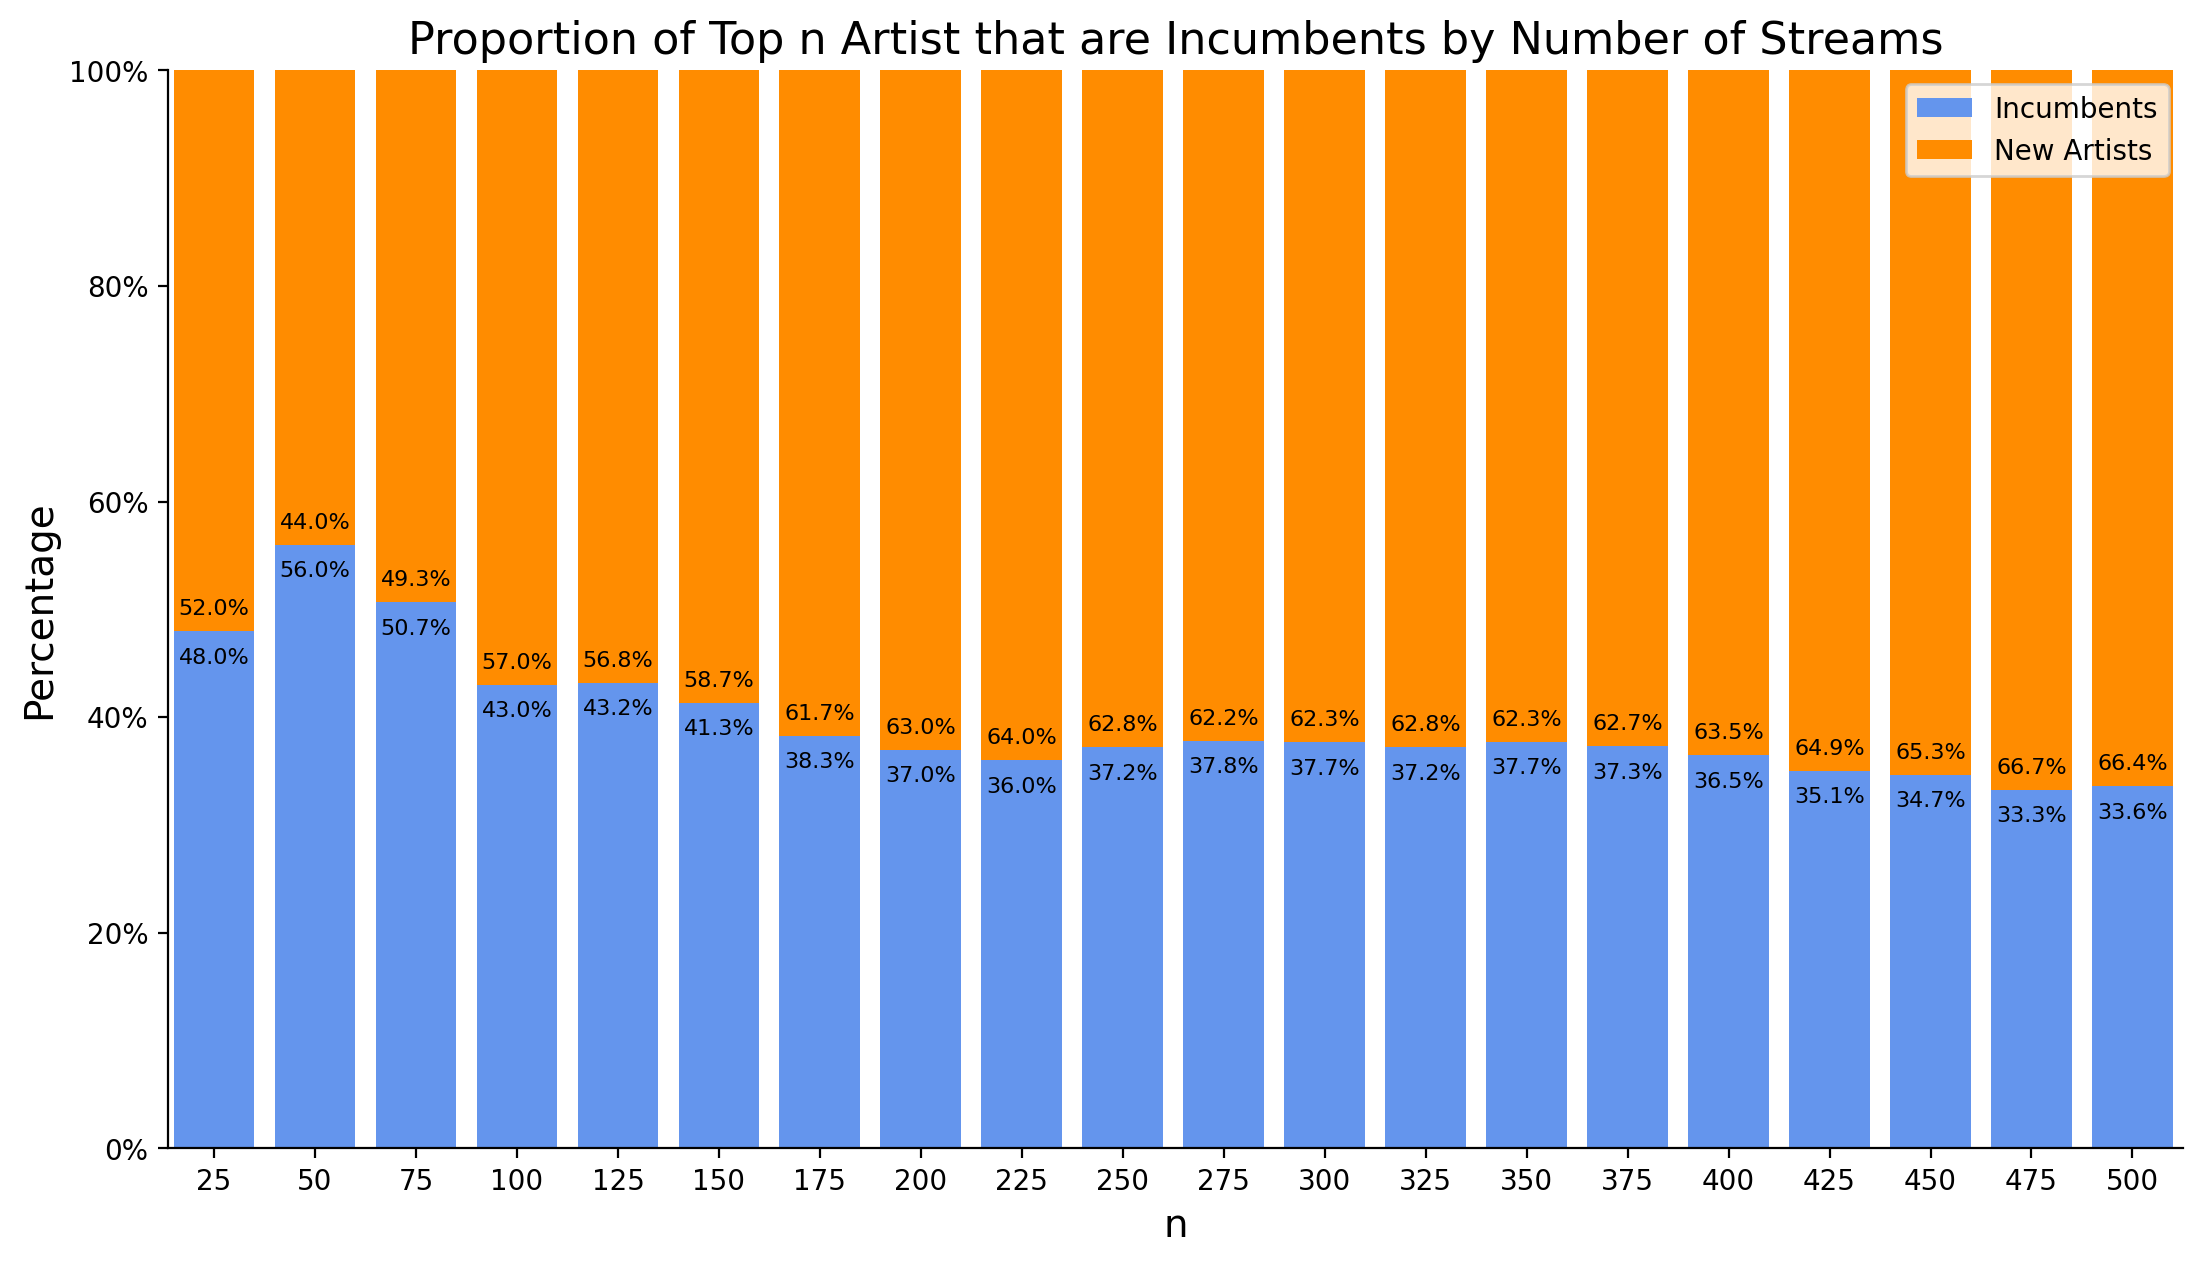

In [59]:
fig, ax = plt.subplots(figsize = (13, 7))

w = 0.8
bar_positions = np.arange(len(labels))

ax.bar(bar_positions, pct_incumbents, w, label='Incumbents', color = plot_settings.colors["blue"])
ax.bar(bar_positions, pct_new_artists, w, bottom=pct_incumbents, label='New Artists', color = plot_settings.colors["orange"])

for i, n in enumerate(to_plot.keys()): 
    ax.annotate(f"{100*to_plot[n][0]:.1f}%", xy = (i, to_plot[n][0]-0.03), ha = "center", fontsize = 8)
    ax.annotate(f"{100*to_plot[n][1]:.1f}%", xy = (i, to_plot[n][0]+0.015), ha = "center", fontsize = 8)

ax.set_xlabel('n')
ax.set_ylabel('Percentage')
ax.set_title('Proportion of Top n Artist that are Incumbents by Number of Streams')
ax.set_xticks(bar_positions)
ax.set_xticklabels(labels)
ax.set_yticks([0, .2, .4, .6, .8, 1])
ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylim(0, 1)
ax.set_xlim(0-w/1.75, 500/25 - 0.5)
ax.legend()

plt.show()